### Import Packages

In [554]:
import numpy as np 
import pandas as pd
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.utils.vis_utils import model_to_dot
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
import pickle
from sklearn.metrics import f1_score
from sklearn.utils import class_weight


### Merge Labeled Datasets, Reddit posts, and Tweets

In [477]:
df5 = pd.read_csv('No Cause.txt', sep = '>', names=['emotion', 'tweet', 'nan'])

In [479]:
df5

,emotion,tweet,nan
0,<happy,This did the trick : the boys now have a more ...,NaN
1,<happy,"When Anna left Inspector Aziz , she was much h...",NaN
2,<happy,"And though , as Lachlan had planned , they had...",NaN
3,<happy,"Honestly , I 'm really happy for you ! <\happy",NaN
4,<happy,Lesley was totally happy about it . <\happy,NaN
...,...,...,...
1572,<shame,He gets real humiliated and has to leave . <\s...,NaN
1573,<shame,They aimed for higher status jobs and felt hum...,NaN
1574,<shame,He cursed his lack of self-control ; he knew t...,NaN
1575,<shame,Sometimes I've thought I 'll never forget wha...,NaN


In [480]:
df5.emotion = df5.emotion.str.strip('<')

In [481]:
df5['tweet'] = df5['tweet'].apply(lambda x: x.split('<')[0])

In [482]:
df5.drop('nan', axis=1, inplace=True)

In [483]:
df5['emotion'] = df5['emotion'].apply(lambda x: 1 if x=='anger' else 0)

In [484]:
df5 = df5[['tweet', 'emotion']]

In [508]:
df5[df5.emotion == 1].tweet.iloc[102]

'I do n\'t care if you \'re offended , that \'s the truth . " '

In [ ]:
df5.emotion.value_counts()

In [ ]:
df6 = pd.concat([df2, df5])

In [ ]:
df6.reset_index()

In [ ]:
df6.reset_index(inplace=True)

In [ ]:
df6.drop('index', axis=1, inplace=True)

In [ ]:
df6.to_pickle('3datasets.pkl')

In [ ]:
df6 = pd.read_pickle('3datasets.pkl')

In [ ]:
df6.drop_duplicates(inplace=True)

In [ ]:
df45 = pd.read_pickle('angry_tweet.pkl')

In [111]:
remove = lambda x: re.sub('\n', '', x)


In [308]:
dash = lambda x: re.sub('[/\\\:?\"]', '', x)


In [311]:
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())


In [ ]:
df7 = pd.concat([df6, df50])

In [ ]:
df7

In [ ]:
df7.reset_index(inplace=True, drop=True)

In [ ]:
df7.to_pickle('dataset.pkl')

In [ ]:
df7 = pd.read_pickle('dataset.pkl')

In [ ]:
df8 = pd.read_pickle('reddit.pkl')

In [ ]:
df8 = df8[['body']]

In [ ]:
df8['emotion'] = 1

In [ ]:
df200 = pd.read_pickle('sad.pkl')

In [ ]:
df200 = df200[['body']]

In [ ]:
df200['emotion'] = 0

In [ ]:
df200 = df200.rename(columns={'body': 'text'})

In [ ]:
df8 = df8.rename(columns={'body': 'text'})

In [ ]:
df7 = df7.rename(columns={'tweet': 'text'})

In [ ]:
df11 = df11[['body']]

In [112]:
remove = lambda x: re.sub('\n', '', x)


In [ ]:
df11['body'] = df11.body.map(remove)

In [106]:
sad = sad[['body']]

In [107]:
sad = sad.rename(columns={'body': 'text'})

In [108]:
sad['emotion'] = 0

In [113]:
sad['text'] = sad['text'].map(remove)

In [ ]:
df20 = df20.rename({'tweet': 'text'}, axis=1)

In [ ]:
df20.drop_duplicates(inplace=True)

In [ ]:
df20.reset_index(inplace=True, drop=True)

In [ ]:
df20.drop('index', axis=1)

In [ ]:
df20.emotion.value_counts()

In [ ]:
df10.to_pickle('final_df.pkl')

In [ ]:
df10.emotion.value_counts()

In [ ]:
happy = pd.read_pickle('happy.pkl')

In [ ]:
happy2 = happy[['title']]

In [ ]:
happy2['emotion'] = 0

In [ ]:
happy2 = happy2.rename({'title': 'text'}, axis=1)

In [ ]:
happy2

In [ ]:
new_df = pd.concat([df7, df8, df200, happy2])

In [ ]:
new_df

In [ ]:
new_df.drop_duplicates(inplace=True)

In [ ]:
new_df.reset_index(inplace=True, drop=True)

In [ ]:
new_df['text'] = new_df.text.map(remove)

In [ ]:
new_df.emotion.value_counts()

In [172]:
new_df.emotion.value_counts()

0    14229
1     4574
Name: emotion, dtype: int64

In [ ]:
new_df.to_pickle('semilast.pkl')

### Modeling with Keras 

In [328]:
new_df = pd.read_pickle('semilast.pkl')

In [654]:
class_weights = dict(zip(np.unique(y_train), class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train))) 

In [587]:
X_train, X_test, y_train2, y_test = train_test_split(new_df.text, new_df.emotion, test_size=0.2)

In [653]:
seq_len = 100  
max_vocab = 1500 

tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(new_df.text)

train_text, val_text, y_train, y_val = train_test_split(X_train, y_train2, 
                                                        test_size=0.2, random_state = 23)

train_text = tokenizer.texts_to_sequences(train_text) 
train_text = pad_sequences(train_text, maxlen=seq_len)

val_text = tokenizer.texts_to_sequences(val_text)
val_text = pad_sequences(val_text, maxlen=seq_len)

In [8]:
import gensim.downloader as api
word_vectors = api.load('glove-wiki-gigaword-50');

In [33]:
embedding_dim = word_vectors.vector_size

In [572]:
word_index = tokenizer.word_index


embedding_dim = word_vectors.vector_size 

embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    try:
        embedding_vector = word_vectors[word.replace("'", "")]
        embedding_matrix[i] = embedding_vector
    except: 
        pass

In [646]:
inp = Input(shape=(seq_len,))
x = Embedding(len(word_index) + 1,
              embedding_dim,
              weights=[embedding_matrix], # where we feed the pretrained vecs
              trainable=False)(inp) # freeze these parameters in the model

x = Bidirectional(LSTM(64, recurrent_dropout=.10))(x)
x = Dense(32)(x) # fully connected layer on top of the output of the bi-LSTM
x = Dropout(.3)(x)
y = Dense(1, activation='sigmoid')(x)

NN = Model(inp, y)
NN.summary()

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
embedding_21 (Embedding)     (None, 100, 50)           1498250   
_________________________________________________________________
bidirectional_21 (Bidirectio (None, 128)               58880     
_________________________________________________________________
dense_42 (Dense)             (None, 32)                4128      
_________________________________________________________________
dropout_21 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 33        
Total params: 1,561,291
Trainable params: 63,041
Non-trainable params: 1,498,250
___________________________________________

In [222]:
custom_early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=1, 
    min_delta=0.001, 
    mode='max'
)

In [565]:
early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=1,
                              verbose=0, mode='auto')

In [660]:
NN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = NN.fit(train_text, y_train, 
                 validation_data=(val_text, y_val),
                 epochs=100, batch_size=64, verbose=1, callbacks=[early_stopping], class_weight=class_weights)

Epoch 1/100
189/189 [==============================] - 22s 116ms/step - loss: 0.2857 - accuracy: 0.8841 - val_loss: 0.3544 - val_accuracy: 0.8558
Epoch 2/100
189/189 [==============================] - 24s 128ms/step - loss: 0.2676 - accuracy: 0.8911 - val_loss: 0.3729 - val_accuracy: 0.8568
Epoch 3/100
189/189 [==============================] - 28s 151ms/step - loss: 0.2589 - accuracy: 0.8950 - val_loss: 0.3700 - val_accuracy: 0.8614


In [643]:
with open('tokenizer4.pkl', 'wb') as handle4:
    pickle.dump(tokenizer, handle4, protocol=pickle.HIGHEST_PROTOCOL)


In [219]:
NN

In [619]:
model = NN

In [620]:
model.save('finalfinal2')

INFO:tensorflow:Assets written to: finalfinal2/assets


In [640]:
seq = tokenizer.texts_to_sequences(X_test)
padded = pad_sequences(seq, maxlen=seq_len)
pred = (NN.predict(padded)[:,0] > .6).astype(int)
print(accuracy_score(y_test, pred))
f1_score(y_test, pred)

0.8261100771071523


0.6546990496304118

In [625]:
padded

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 401,
         41,  21, 163,  12,  68,  41, 214, 136,  21]], dtype=int32)

In [667]:
new_complaint = ['I hate the assignment. Do it again.']

seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=seq_len)
pred = NN.predict(padded)
print(pred)

[[0.49282366]]


In [ ]:
['I do not like the assignment you turned in. Do it again.']
['Please do this assignment again. You can do better than this.']

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Accuracy vs. Training Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Validation'])

### Confusion Matrix

In [375]:
from sklearn.metrics import confusion_matrix


Text(112.25000000000007, 0.5, 'actual')

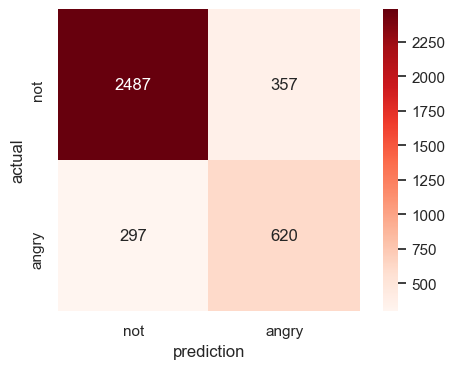

In [642]:
seq = tokenizer.texts_to_sequences(X_test)
padded = pad_sequences(seq, maxlen=seq_len)
pred = (NN.predict(padded)[:,0] > .6).astype(int)
fraud_confusion = confusion_matrix(y_test, pred)
plt.figure(dpi=100)
sns.heatmap(fraud_confusion, cmap=plt.cm.Reds, annot=True, square=True, fmt='d',
    xticklabels=['not', 'angry'],
    yticklabels=['not', 'angry']);
plt.xlabel('prediction')
plt.ylabel('actual')